### Steel Defect Detection 

This is basic kernel to start participating in this competition.
It shows how to use PyTorch for solving the segmentation problem.
If you prefer to use Keras, I also created others basic Kernels: 
1. https://www.kaggle.com/ateplyuk/keras-starter-segmentation
1. https://www.kaggle.com/ateplyuk/keras-starter-u-net

Architecture of Model is U-Net with pretrained encoder. In our case it ResNet18.

![](https://github.com/ushur/Severstal-Steel-Defect-Detection/blob/master/unet.jpg?raw=true)

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

### Read train dataframe

In [2]:
path = '../input/severstal-steel-defect-detection/'

In [3]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head(6)

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN


#### To simplify and speed up process, n this kernel I use only images with ClassId=4

In [4]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


### Decode mask

In [5]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Display some images

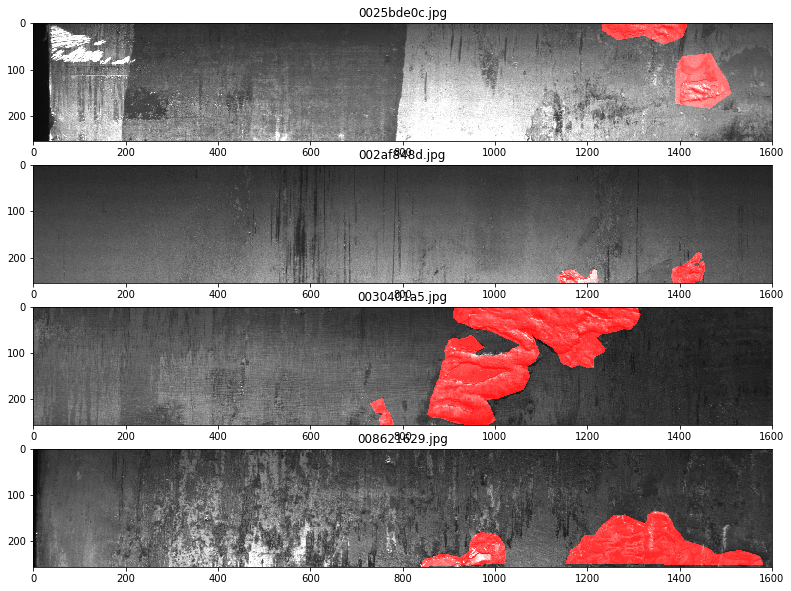

In [6]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset and DataLoader

In [7]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

In [8]:
data_transf = transforms.Compose([
                                  transforms.Scale((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=4)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:209: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### Show some image and mask

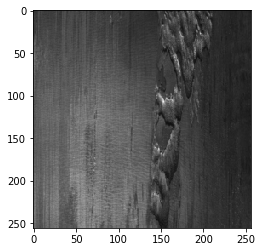

In [9]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

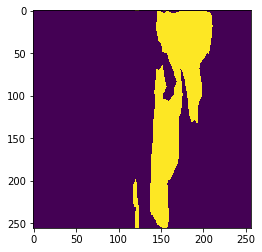

In [10]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

### Create U-Net Model

In [11]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
# copied from 682
# model = nn.Sequential(
#     nn.Conv2d(3, 64, 3, padding=1, stride=1),
#     nn.BatchNorm2d(64),
#     nn.ELU(),
#     nn.Conv2d(64, 64, 3, padding=1, stride=1),
#     nn.BatchNorm2d(64),
#     nn.ELU(),
#     nn.MaxPool2d(2), #32/2
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load("../input/resnet18/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [12]:
model = UNet(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)

### Training

In [13]:
%%time
for epoch in range(5):      
    model.train()         
    for ii, (data, target) in enumerate(train_loader):                         
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()          
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 - Loss: 0.003061
Epoch: 2 - Loss: 0.002489
Epoch: 3 - Loss: 0.002352
Epoch: 4 - Loss: 0.002288
Epoch: 5 - Loss: 0.002243
CPU times: user 1min 19s, sys: 8.36 s, total: 1min 27s
Wall time: 1min 31s


### Show prediction on image from train dataset

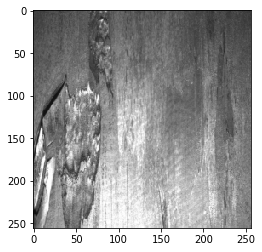

In [14]:
plt.imshow(train_data[6][0].permute(1, 2, 0))

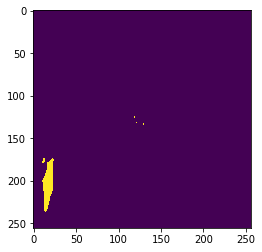

In [15]:
x = train_data[6][0].unsqueeze(0)
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

### Read submit file

In [16]:
submit = pd.read_csv(path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '})
print(len(submit))
sub4 = submit[submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')]
print(len(sub4))
sub4.head()

7204
1801


,ImageId_ClassId,EncodedPixels
3,004f40c73.jpg_4,
7,006f39c41.jpg_4,
11,00b7fb703.jpg_4,
15,00bbcd9af.jpg_4,
19,0108ce457.jpg_4,


### Create test Dataset and DataLoader

In [17]:
test_data = ImageData(df = sub4, transform = data_transf, subset="test")
test_loader = DataLoader(dataset = test_data, shuffle=False)

### Prediction

In [18]:
%%time
predict = []
model.eval()
for data in test_loader:
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy() * (-1)    
    predict.append(abs(output[0]))

CPU times: user 25.4 s, sys: 6.36 s, total: 31.8 s
Wall time: 36.3 s


### Encode mask 

In [19]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Resize images

In [20]:
%%time
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

CPU times: user 27min 15s, sys: 908 ms, total: 27min 16s
Wall time: 27min 14s


### Prepare submission file

In [21]:
submit['EncodedPixels'][submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')] = pred_rle
submit.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,21642 36 21898 36 22154 36 22410 36 22666 36 2...
4,006f39c41.jpg_1,


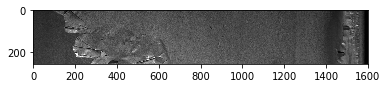

In [22]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

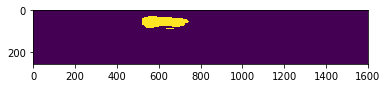

In [23]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [24]:
submit.head(10)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,21642 36 21898 36 22154 36 22410 36 22666 36 2...
4,006f39c41.jpg_1,
5,006f39c41.jpg_2,
6,006f39c41.jpg_3,
7,006f39c41.jpg_4,151422 12 151678 12 151934 12 152190 12 152446...
8,00b7fb703.jpg_1,
9,00b7fb703.jpg_2,


In [25]:
submit.to_csv('submission.csv', index=False)